# MSXVI - FSGP & ASC '25 - Strategy
by Kostubh Agarwal & Rodrigo Tiscareno

## About
FSGP serves as a qualifying event for ASC. The objectives of FSGP are the following:

"Scoring is based on the highest overall official distance driven or laps completed over the duration of the event with ties being broken by the lowest overall official elapsed time or fastest lap" in other words maximising distance for a fixed time. 

The objectives of ASC are the following:

1. To complete the American Solar Challenge base route without trailering.
2. To complete as many official miles as possible. (1st Tiebreaker)
3. To complete the distance in the shortest elapsed time. (2nd Tiebreaker)

Successfully achieving these objectives hinges on two critical factors: designing an efficient solar car and following a good race strategy. Race strategy boils down to a single question:

### **What speed should one drive at?**

To address this question, the code below leverages comprehensive data inputs including route models, elevation profiles, weather conditions, and solar irradiance data. This integrated approach allows for predicting the performance of the solar car across various velocities.

At the core of the analysis is a solver that computes the instantaneous power draw and supply from multiple sources, including:

- **Drag Resistance**: Calculated based on vehicle aerodynamics, wind and velocity.
- **Rolling Resistance**: Determined by the surface conditions of the road, weight of the car and the car's tires.
- **Gradient Resistance**: Accounts for uphill and downhill sections of the route.
- **Solar Irradiance**: Utilizes Global Tilted Irradiance (GTI) data, which considers the angle of the sun relative to the car's solar panels. This data helps estimate the available solar energy for electricity generation. *(Courtesy of [Solcast](https://solcast.com/irradiance-data-methodology))*

These factors are computed dynamically over time and distance to simulate and optimize the car's performance during the race.

## Database

The database is comprised of two tables: the route model and a solar irradiance table. The database is intended to be stored locally and synced with a cloud version based on availability of internet. The cloud database is regularly updated with the latest route model and solar irradiance data. This design enables the local solver to run offline with high performance and reliability. 

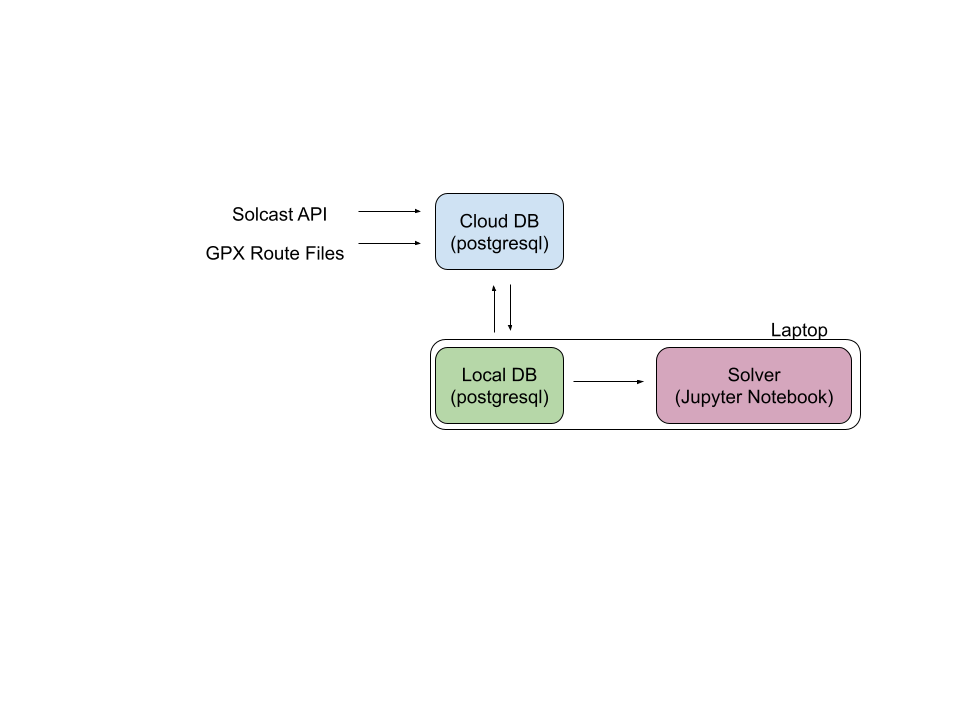

**The cell below syncs the local database with the cloud database.**

*Pre-requisite: Wi-fi*

In [ ]:
def map_distance_to_id(base_route_df, route_symbol, distance):
    df = base_route_df[base_route_df["symbol"] == route_symbol].copy()
    df["distance_difference"] = abs(df["stage_elapsed_distance"] - distance)
    result_df = df.nsmallest(1, "distance_difference")
    return result_df


def map_distance_to_irradiance(
    irradiance_df,
    base_route_df,
    route_symbol,
    distance,
    time,
    start_time=None,
):
    df = base_route_df[base_route_df["symbol"] == route_symbol].copy()
    df["distance_difference"] = abs(df["stage_elapsed_distance"] - distance)
    stage_id, route_start_time = df.nsmallest(1, "distance_difference")[
        ["stage_id", "route_start_time"]
    ].values[0]

    if start_time:
        route_start_time = start_time

    time = int(time)
    target_time = route_start_time + timedelta(seconds=time)

    irradiance_df["time_difference"] = abs(
        (irradiance_df["period_end"] - target_time).dt.total_seconds()
    )
    result_df = irradiance_df[irradiance_df["route_model_id"] == stage_id].nsmallest(
        1, "time_difference"
    )
    return result_df

In [3]:
from sync import main as sync
sync("irradiance")
sync("base_route")

Connecting to cloud database...


Additionally, for increased performance, the local database is then stored in memory as a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

**This cell is a pre-requisite for all the following cells.**

In [1]:
from db_funcs import load_data_to_memory
import pandasql as psql
from datetime import datetime

base_route_df, irradiance_df = load_data_to_memory()

OperationalError: connection to server at "34.121.96.129", port 5432 failed: Connection timed out (0x0000274C/10060)
	Is the server running on that host and accepting TCP/IP connections?


## Route Overview

The following cells provide distances of each stage, elevation profiles, and irradiance data for a given stage.

| Route Name                       | Symbol |
|----------------------------------|--------|
| Nashville to Paducah             | 1A     |
| Paducah to Edwardsville          | 1B     |
| Edwardsville to Jefferson City   | 2C     |
| Jefferson City to Independence   | 2D     |
| Independence to Saint Joseph     | 2E     |
| Saint Joseph to Beatrice         | 3F     |
| Beatrice to Kearney              | 3G     |
| Kearney to Gering                | 3H     |
| Gering to Casper                 | 4J     |

#### Setup

In [55]:
import datetime as dt

STAGE_SYMBOL = '1B'
start_time = datetime(year=2024, month=7, day=10, hour=10, minute=10) # start_time is the current time DEFINED IN UTC

#### Distance (Stage)

In [56]:
import pandasql as psql
import pandas as pd
import matplotlib.pyplot as plt

query = f"""
SELECT stage_elapsed_distance 
FROM base_route_df
WHERE symbol='{STAGE_SYMBOL}' 
ORDER BY id DESC 
LIMIT 1"""
df = psql.sqldf(query, locals())

stage_d = df['stage_elapsed_distance'].values[0]

print(f'Stage {STAGE_SYMBOL} total distance: {stage_d/1000:.2f} km')

Stage 1B total distance: 349.72 km


#### Elevation Profile (Stage)

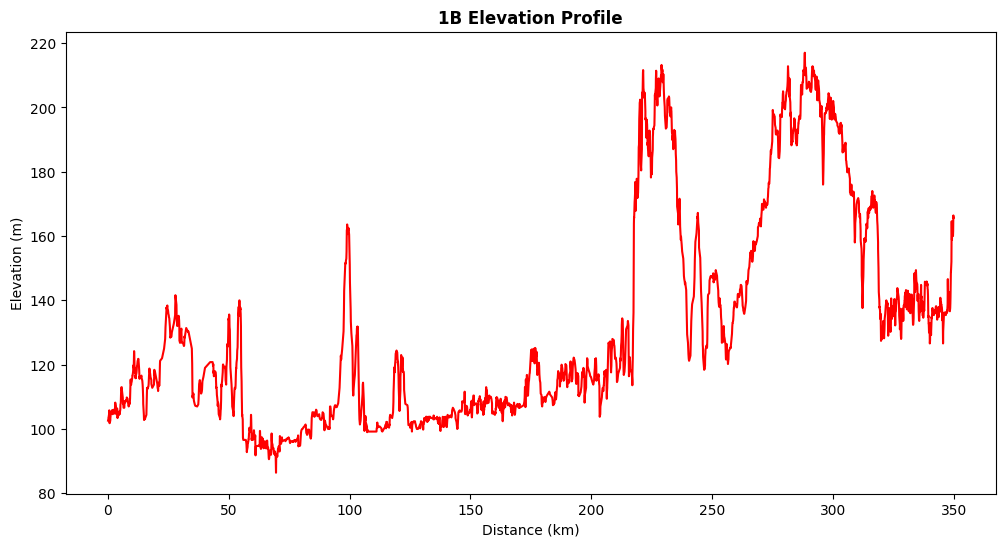

In [57]:
import pandasql as psql
import pandas as pd
import matplotlib.pyplot as plt

query = f"""
SELECT * 
FROM base_route_df 
WHERE symbol = '{STAGE_SYMBOL}' 
ORDER BY id"""
df = psql.sqldf(query, locals())

df['stage_elapsed_distance_km'] = df['stage_elapsed_distance'] / 1000
window_size = 5
df['moving_avg_elevation'] = df['elevation'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['stage_elapsed_distance_km'], df['moving_avg_elevation'], color='red')
plt.title(f'{STAGE_SYMBOL} Elevation Profile', fontweight='bold')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')

plt.show()

#### Elevation Profile (Total)

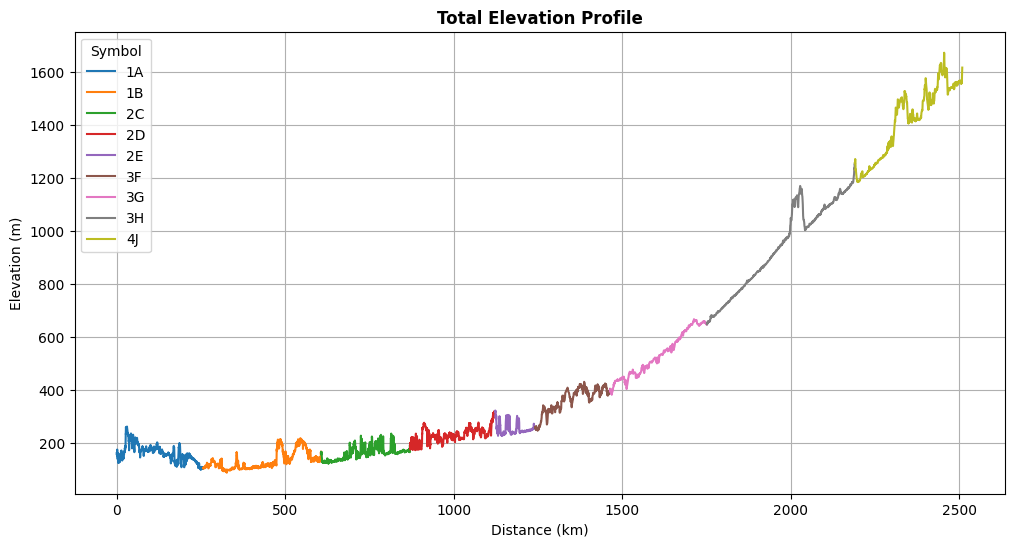

In [58]:
import pandasql as psql
import pandas as pd
import matplotlib.pyplot as plt

query = "SELECT * FROM base_route_df ORDER BY id"
df = psql.sqldf(query, locals())

df['geopy_elapsed_dist_km'] = df['geopy_elapsed_dist_m'] / 1000

window_size = 5
df['moving_avg_elevation'] = df['elevation'].rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))

for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol]
    plt.plot(subset['geopy_elapsed_dist_km'], subset['moving_avg_elevation'], label=symbol)

plt.title('Total Elevation Profile', fontweight='bold')
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.legend(title='Symbol')
plt.grid(True)

plt.show()


#### Irradiance (3-day)

In [ ]:
from db_funcs import map_distance_to_id
from db_funcs import fetch_data
import matplotlib.dates as mdates
import pandasql as psql
import pandas as pd
import matplotlib.pyplot as plt

query = f"""

SELECT *
FROM irradiance_df
WHERE substr(route_model_id, 1, 2) = '{STAGE_SYMBOL}'
ORDER BY period_end;"""

df = psql.sqldf(query, locals())

unique_routes = sorted(df['route_model_id'].unique())

middle_route = unique_routes[len(unique_routes) // 2]

forecasted_data = df[df['route_model_id'] == middle_route]

forecasted_data = forecasted_data.drop_duplicates(subset=['period_end'])

forecasted_data['period_end'] = pd.to_datetime(forecasted_data['period_end'])

start_date_input = input("Enter the start date (YYYY-MM-DD): ")
end_date_input = input("Enter the end date (YYYY-MM-DD): ")

start_date = pd.to_datetime(start_date_input)
end_date = pd.to_datetime(end_date_input)

filtered_data = forecasted_data[(forecasted_data['period_end'].dt.date >= start_date.date()) & (forecasted_data['period_end'].dt.date <= end_date.date())]

fixed_date = dt.datetime(1900, 1, 1)

filtered_data['time_of_day'] = filtered_data['period_end'].apply(lambda x: fixed_date.replace(hour=x.hour, minute=x.minute, second=x.second))

unique_dates = filtered_data['period_end'].dt.date.unique()

plt.figure(figsize=(12, 6))

for unique_date in unique_dates:
    daily_data = filtered_data[filtered_data['period_end'].dt.date == unique_date]
    plt.plot(daily_data['time_of_day'], daily_data['ghi'], marker='o', label=str(unique_date))

plt.title('Average Forecasted GTI Over Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Global Horizontal Irradiance (GTI)')
plt.xticks(rotation=45)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_minor_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.legend(title='Date')
plt.tight_layout()
plt.show()


## Solver

Run the following cell to simulate the car at varying velocities. The solver can simulate up to 8 hours ahead. It does not include an error minimization function. This is intentional due to limited real-world feedback from telemetry and diagnostics. Therefore, it is more important for the solver's behavior to be predictable rather than accurate.

**Re-run the simulation as frequently as possible using real-time distance values to keep errors in check.**

In [59]:
## Setup
STAGE_SYMBOL = "1B"
current_d = 0 # current distance along stage (m)
start_time = datetime(year=2024, month=7, day=10, hour=10, minute=10) # simulation start time DEFINED IN UTC.

In [60]:
import numpy as np
from tqdm import tqdm
from db_funcs import map_distance_to_id, map_distance_to_irradiance, load_data_to_memory
from datetime import datetime, timedelta

# Constants
m = 300.0  # mass of the vehicle (kg)
g = 9.81  # acceleration due to gravity (m/s^2)
C_r1 = 0.004  # rolling resistance coefficient 1
C_r2 = 0.052  # rolling resistance coefficient 2
C_d = 0.13  # drag coefficient
A_drag = 1.357  # cross-sectional area (m^2)
p = 1.293  # air density (kg/m^3)
n = 0.16  # efficiency of solar panel (%)
A_solar = 4.0  # area of solar panel (m^2)
bat_capacity = 40 * 3.63 * 36  # pack capacity (Wh)

# Power (In/Out)
def rolling_resistance(v):
    """Calculate power drawn due to rolling resistance."""
    return (m * g * C_r1 + 4 * C_r2 * v) * v

def drag_resistance(v):
    """Calculate power drawn due to drag."""
    return 0.5 * p * C_d * A_drag * v ** 3

def gradient_resistance(v, theta):
    """Calculate power drawn due to gradients."""
    return m * g * np.sin(theta) * v

def solar_power(G):
    """Calculate power available from solar irradiance."""
    return A_solar * G * n

# Simulation parameters
disc = 32  # discretization
inter = 900  # time intervals

# Initialize arrays
velocities = np.arange(1, 1 + disc)
times = np.arange(1, inter * disc, inter)
solar_power_values = np.zeros((disc, disc))
rolling_resistance_values = np.zeros((disc, disc))
drag_resistance_values = np.zeros((disc, disc))
gradient_resistance_values = np.zeros((disc, disc))
capacity_values = np.full((disc, disc), bat_capacity)

# Load data into memory
base_route_df, irradiance_df = load_data_to_memory()

# Progress bar
pbar = tqdm(total=disc ** 2, desc="Simulating", unit="step")

# Perform simulation
for i, v in enumerate(velocities):
    for j, t in enumerate(times):
        try:
            d = current_d + v * t
            elev_1 = map_distance_to_id(base_route_df, STAGE_SYMBOL, d)['elevation'].values[0]
            elev_2 = map_distance_to_id(base_route_df, STAGE_SYMBOL, d * 2)['elevation'].values[0]
            v_wind = map_distance_to_irradiance(irradiance_df, base_route_df, STAGE_SYMBOL, d, t, start_time=start_time)['wind_speed_10m'].values[0] * np.cos(
                np.deg2rad(map_distance_to_id(base_route_df, STAGE_SYMBOL, d)['car_bearing'].values[0] - map_distance_to_irradiance(irradiance_df, base_route_df, STAGE_SYMBOL, d, t, start_time=start_time)['wind_direction_10m'].values[0]))

            v_adj = v_wind + v
            theta = np.arctan((elev_2 - elev_1) / d)
            irradiance = map_distance_to_irradiance(irradiance_df, base_route_df, STAGE_SYMBOL, d, t, start_time=start_time)['gti'].values[0]

            solar_power_values[i, j] = solar_power(irradiance)
            rolling_resistance_values[i, j] = rolling_resistance(v)
            drag_resistance_values[i, j] = drag_resistance(v_adj)
            gradient_resistance_values[i, j] = gradient_resistance(v, theta)

        except IndexError:
            print("INDEX ERROR")
            exit

        pbar.update(1)

pbar.close()

# Calculate energy consumed
energy_consumed = - solar_power_values + rolling_resistance_values + drag_resistance_values + gradient_resistance_values

# Calculate battery capacity over time
for j in range(1, disc):
    capacity_values[:, j] = capacity_values[:, j - 1] - energy_consumed[:, j - 1]

print(f"8hr simulation for Stage {STAGE_SYMBOL} from {current_d/1000} km @ {start_time} COMPLETE.")

Simulating: 100%|██████████| 1024/1024 [03:30<00:00,  4.87step/s]

8hr simulation for Stage 1B from 0.0 km @ 2024-07-10 10:10:00 COMPLETE.


## Data Visualizations
*Pre-requisite: Run the solver cell*

### Velocity Selection

Plot the distance traveled and battery capacity as a function of velocity and time. 


Plotting: 100%|██████████| 1024/1024 [00:01<00:00, 634.37step/s]


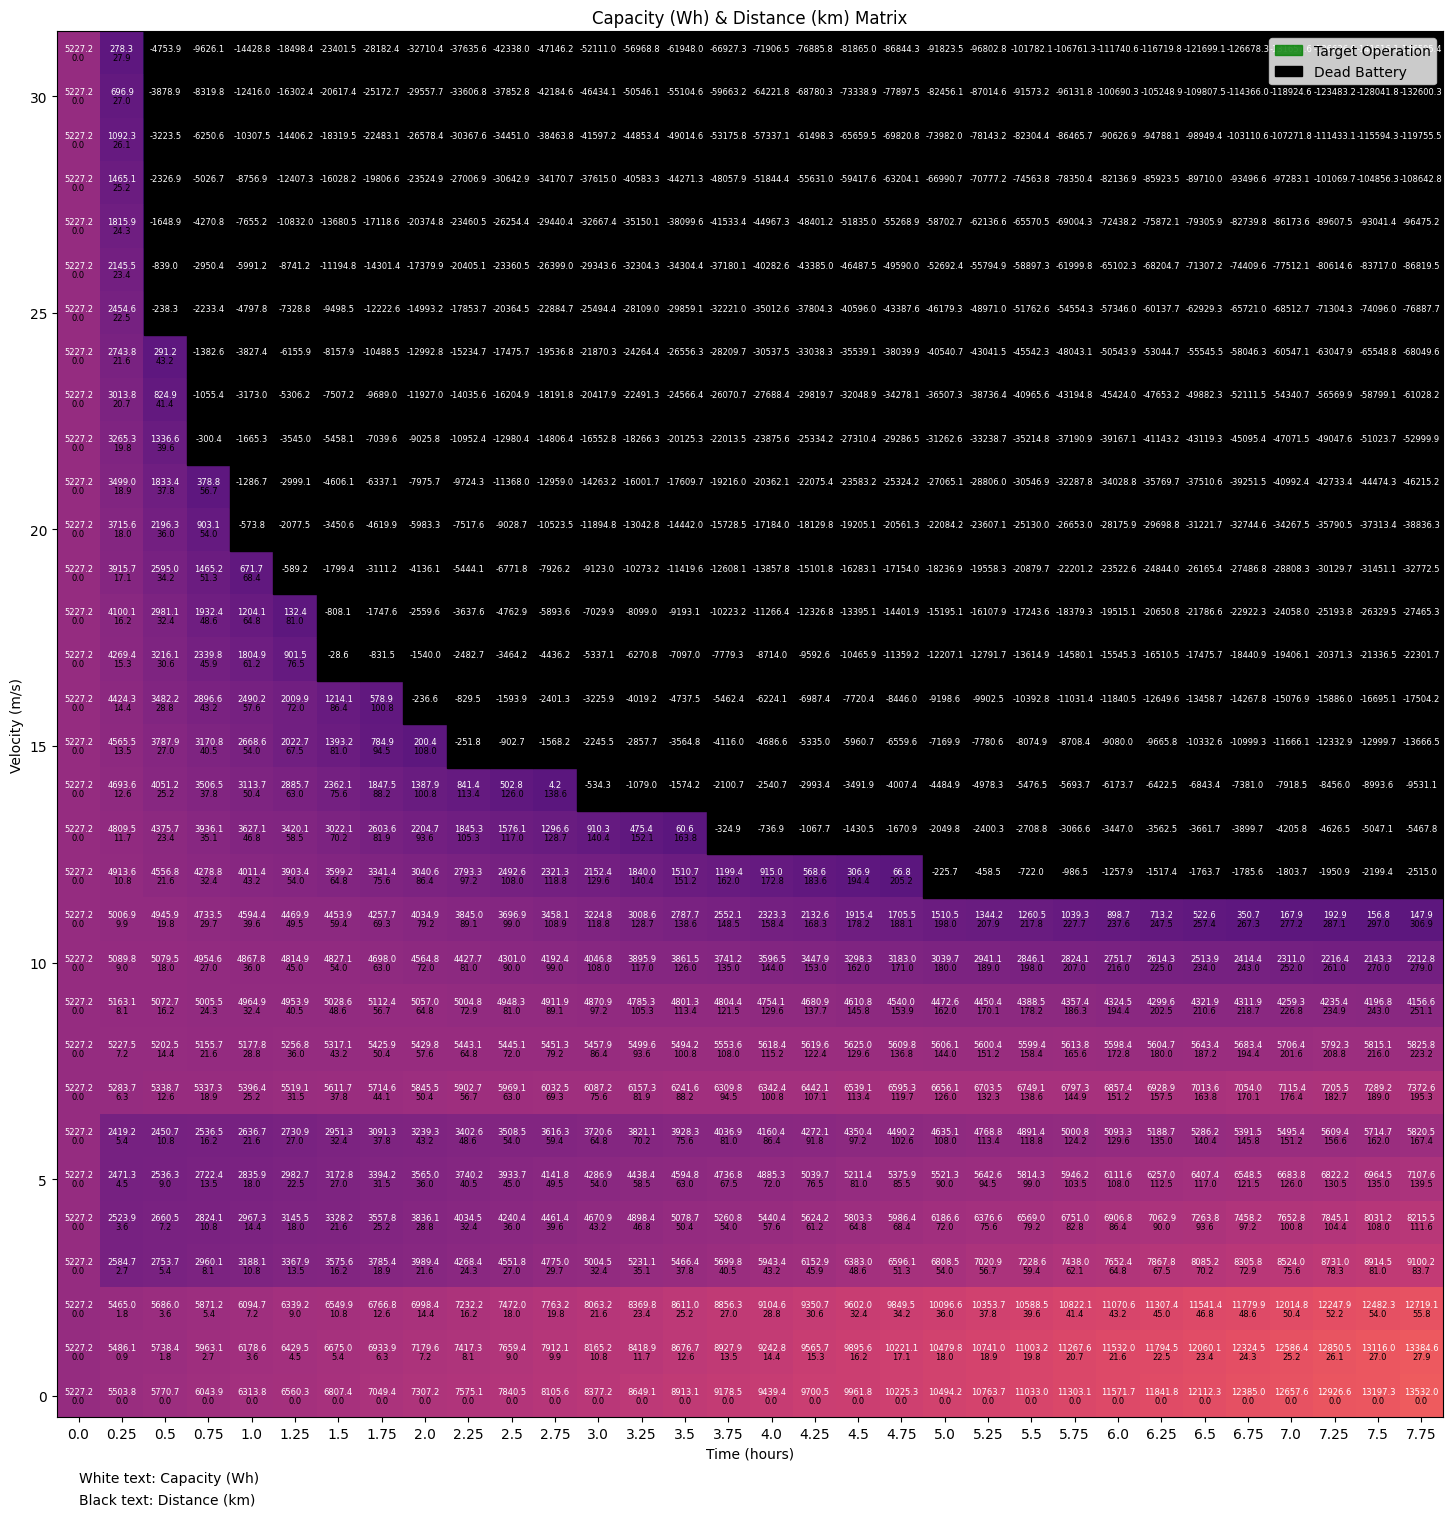

In [61]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 18)) 
plt.title('Capacity (Wh) & Distance (km) Matrix')
plt.xlabel('Time (hours)')
plt.ylabel('Velocity (m/s)')
plt.imshow(capacity_values, cmap='magma', vmin=-10000, vmax=26000)
ax = plt.gca()

pbar = tqdm(total=disc**2, desc="Plotting", unit="step")

for (i, j), val in np.ndenumerate(capacity_values):
    d = (current_d + i * j * inter) / 1000
    if d > stage_d / 1000 and val > 0:
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green', alpha=0.8)
        ax.add_patch(rect)
    if val < 0:
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black', alpha=1)
        ax.add_patch(rect)
    plt.text(j, i, f'{val:.1f}', ha='center', va='bottom', color='white', fontsize=6)
    plt.text(j, i, f'{d:.1f}', ha='center', va='top', color='black', fontsize=6)
    pbar.update(1)

pbar.close()

plt.xticks(ticks=np.arange(0, capacity_values.shape[1]), labels=[f'{i / 4}' for i in range(capacity_values.shape[1])])
plt.text(0, -2.5, 'Black text: Distance (km)', color='black', fontsize=10)
plt.text(0, -2, 'White text: Capacity (Wh)', color='black', fontsize=10)
plt.gca().invert_yaxis()

# Adding legend
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color='green', alpha=0.8, label='Target Operation'),
    plt.Rectangle((0, 0), 1, 1, color='black', alpha=1, label='Dead Battery')
]
plt.legend(handles=legend_patches, loc='upper right', fontsize=10)

plt.show()

## Instantaneous Power Flow Profiles

This visualization presents the power in / out on an discretized time basis for a given velocity.

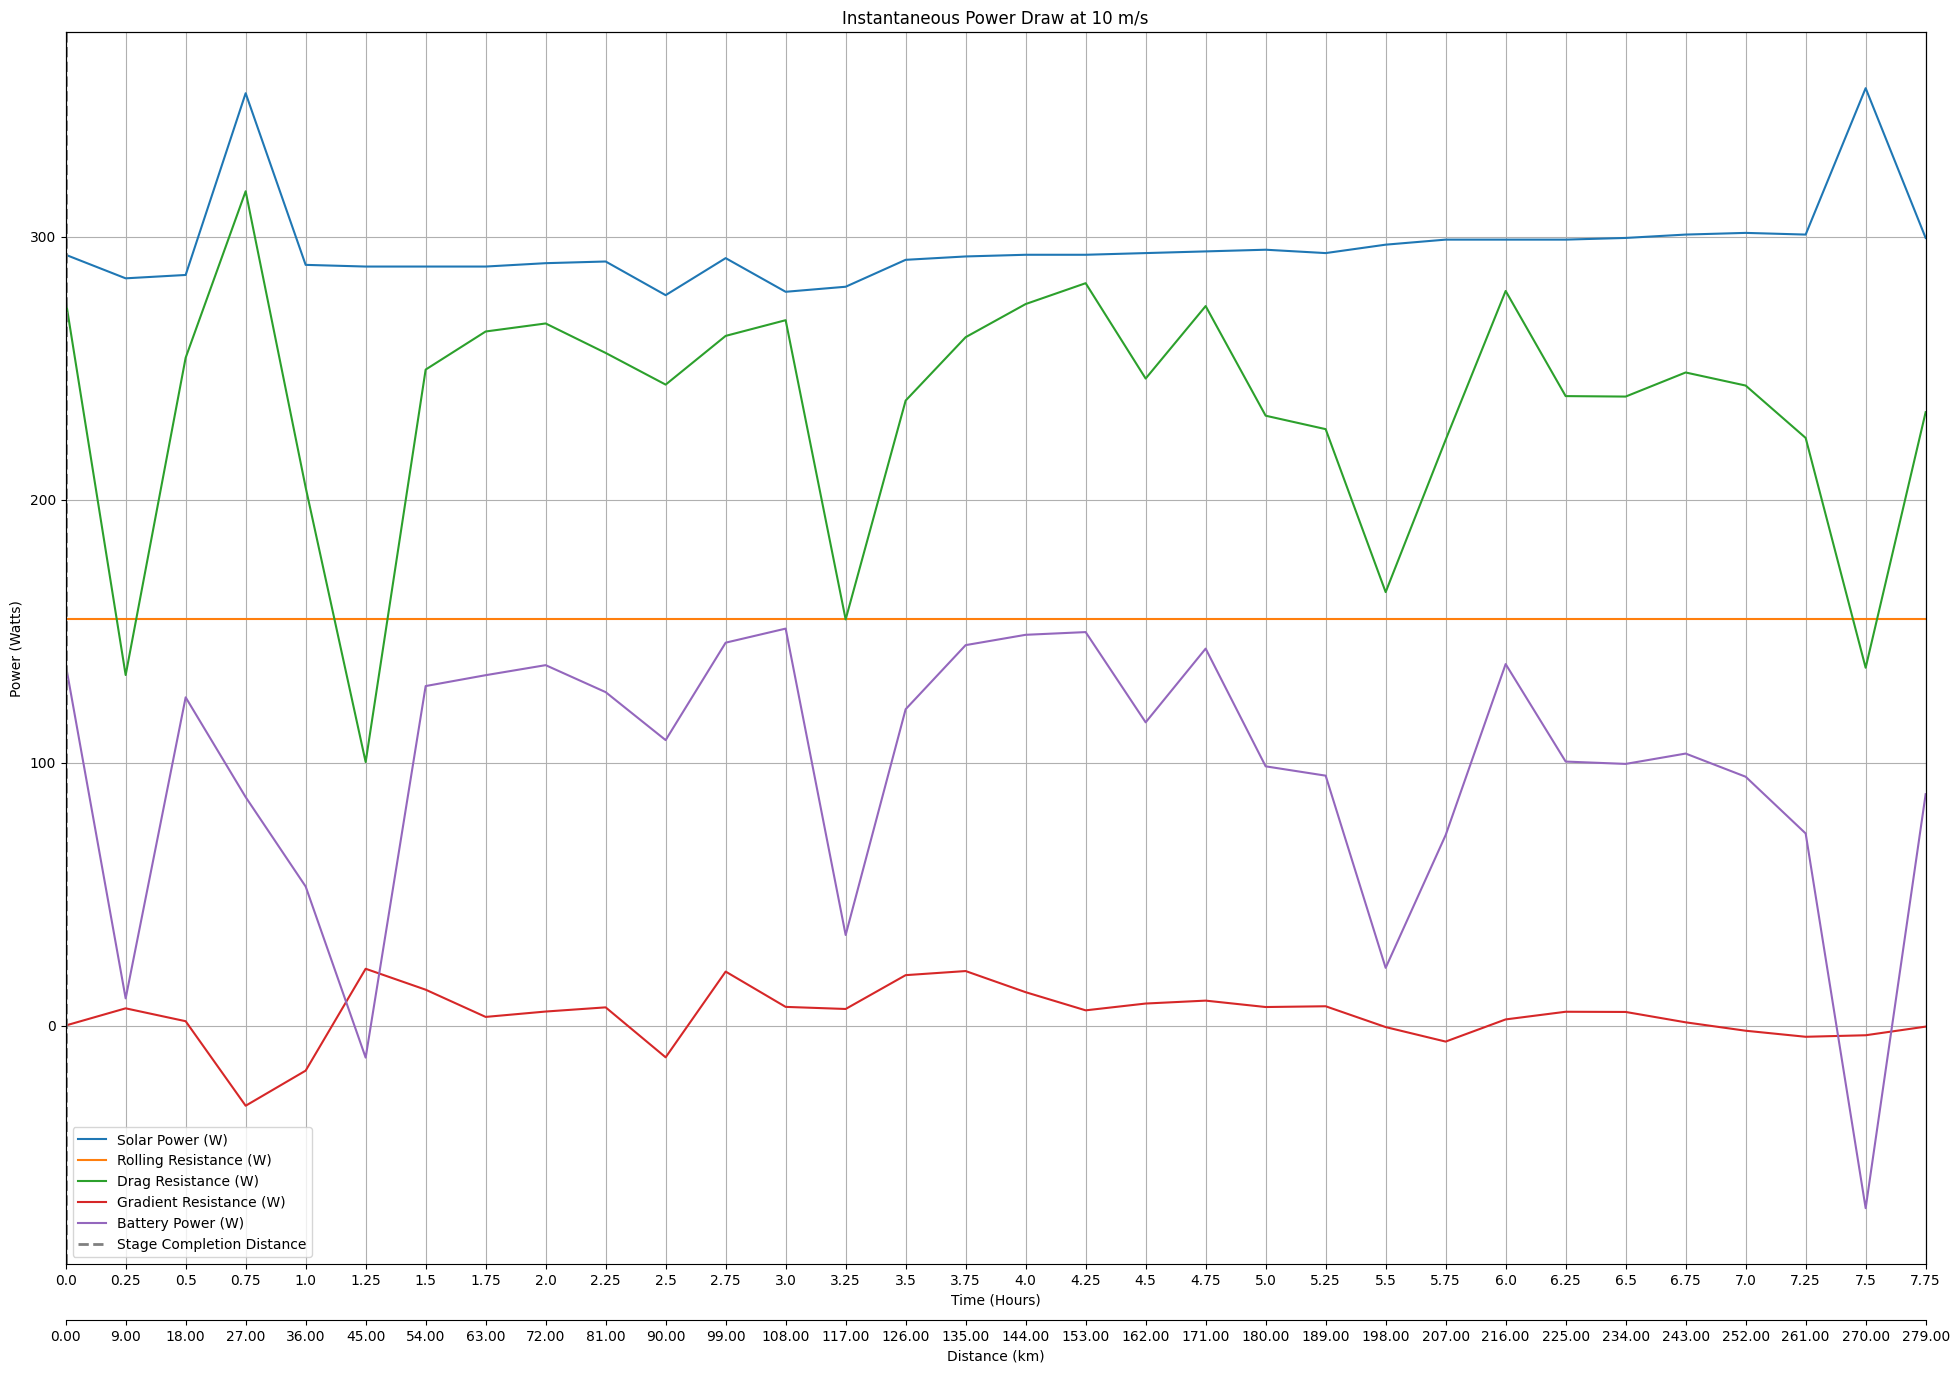

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_power_profiles(velocity, plot_solar=True, plot_rolling=True, plot_drag=True, plot_gradient=True, plot_consumed=True):
    fig, ax1 = plt.subplots(figsize=(24, 16))
    
    if plot_solar:
        ax1.plot(solar_power_values[velocity, :], label='Solar Power (W)')
    if plot_rolling:
        ax1.plot(rolling_resistance_values[velocity, :], label='Rolling Resistance (W)')
    if plot_drag:
        ax1.plot(drag_resistance_values[velocity, :], label='Drag Resistance (W)')
    if plot_gradient:
        ax1.plot(gradient_resistance_values[velocity, :], label='Gradient Resistance (W)')
    if plot_consumed:
        ax1.plot(energy_consumed[velocity, :], label='Battery Power (W)')
    
    ax1.set_xlabel('Time (Hours)')
    ax1.set_ylabel('Power (Watts)')
    ax1.set_title(f'Instantaneous Power Draw at {velocity} m/s')
    ax1.set_xticks(np.arange(0, capacity_values.shape[1]))
    ax1.set_xticklabels([f'{i/4}' for i in range(capacity_values.shape[1])])

    ax2 = ax1.twiny()
    ax2.set_xlabel('Distance (km)')
    ax2.set_xticks(np.arange(0, capacity_values.shape[1]))
    ax2.set_xticklabels([f'{(current_d+velocity*inter*i)/1000:.2f}' for i in range(capacity_values.shape[1])])
    
    x_values = np.arange(0, capacity_values.shape[1])
    threshold_index = np.argmax((current_d + velocity * inter * x_values) / 1000 >= stage_d/1000)  
    ax1.axvline(x=x_values[threshold_index], color='grey', linestyle='--', linewidth=2, label='Stage Completion Distance')
    ax1.legend(loc='upper right') 

    ax1.set_xlim(ax2.get_xlim())
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 40))  

    ax1.legend()
    ax1.grid(True)
    
    plt.show()

#User Input
velocity = 10
plot_power_profiles(velocity, plot_solar=True, plot_rolling=True, plot_drag=True, plot_gradient=True, plot_consumed=True) # Toggle plots


## Battery Capacity Profile

Instantaneous battery capacity based on a given velocity.

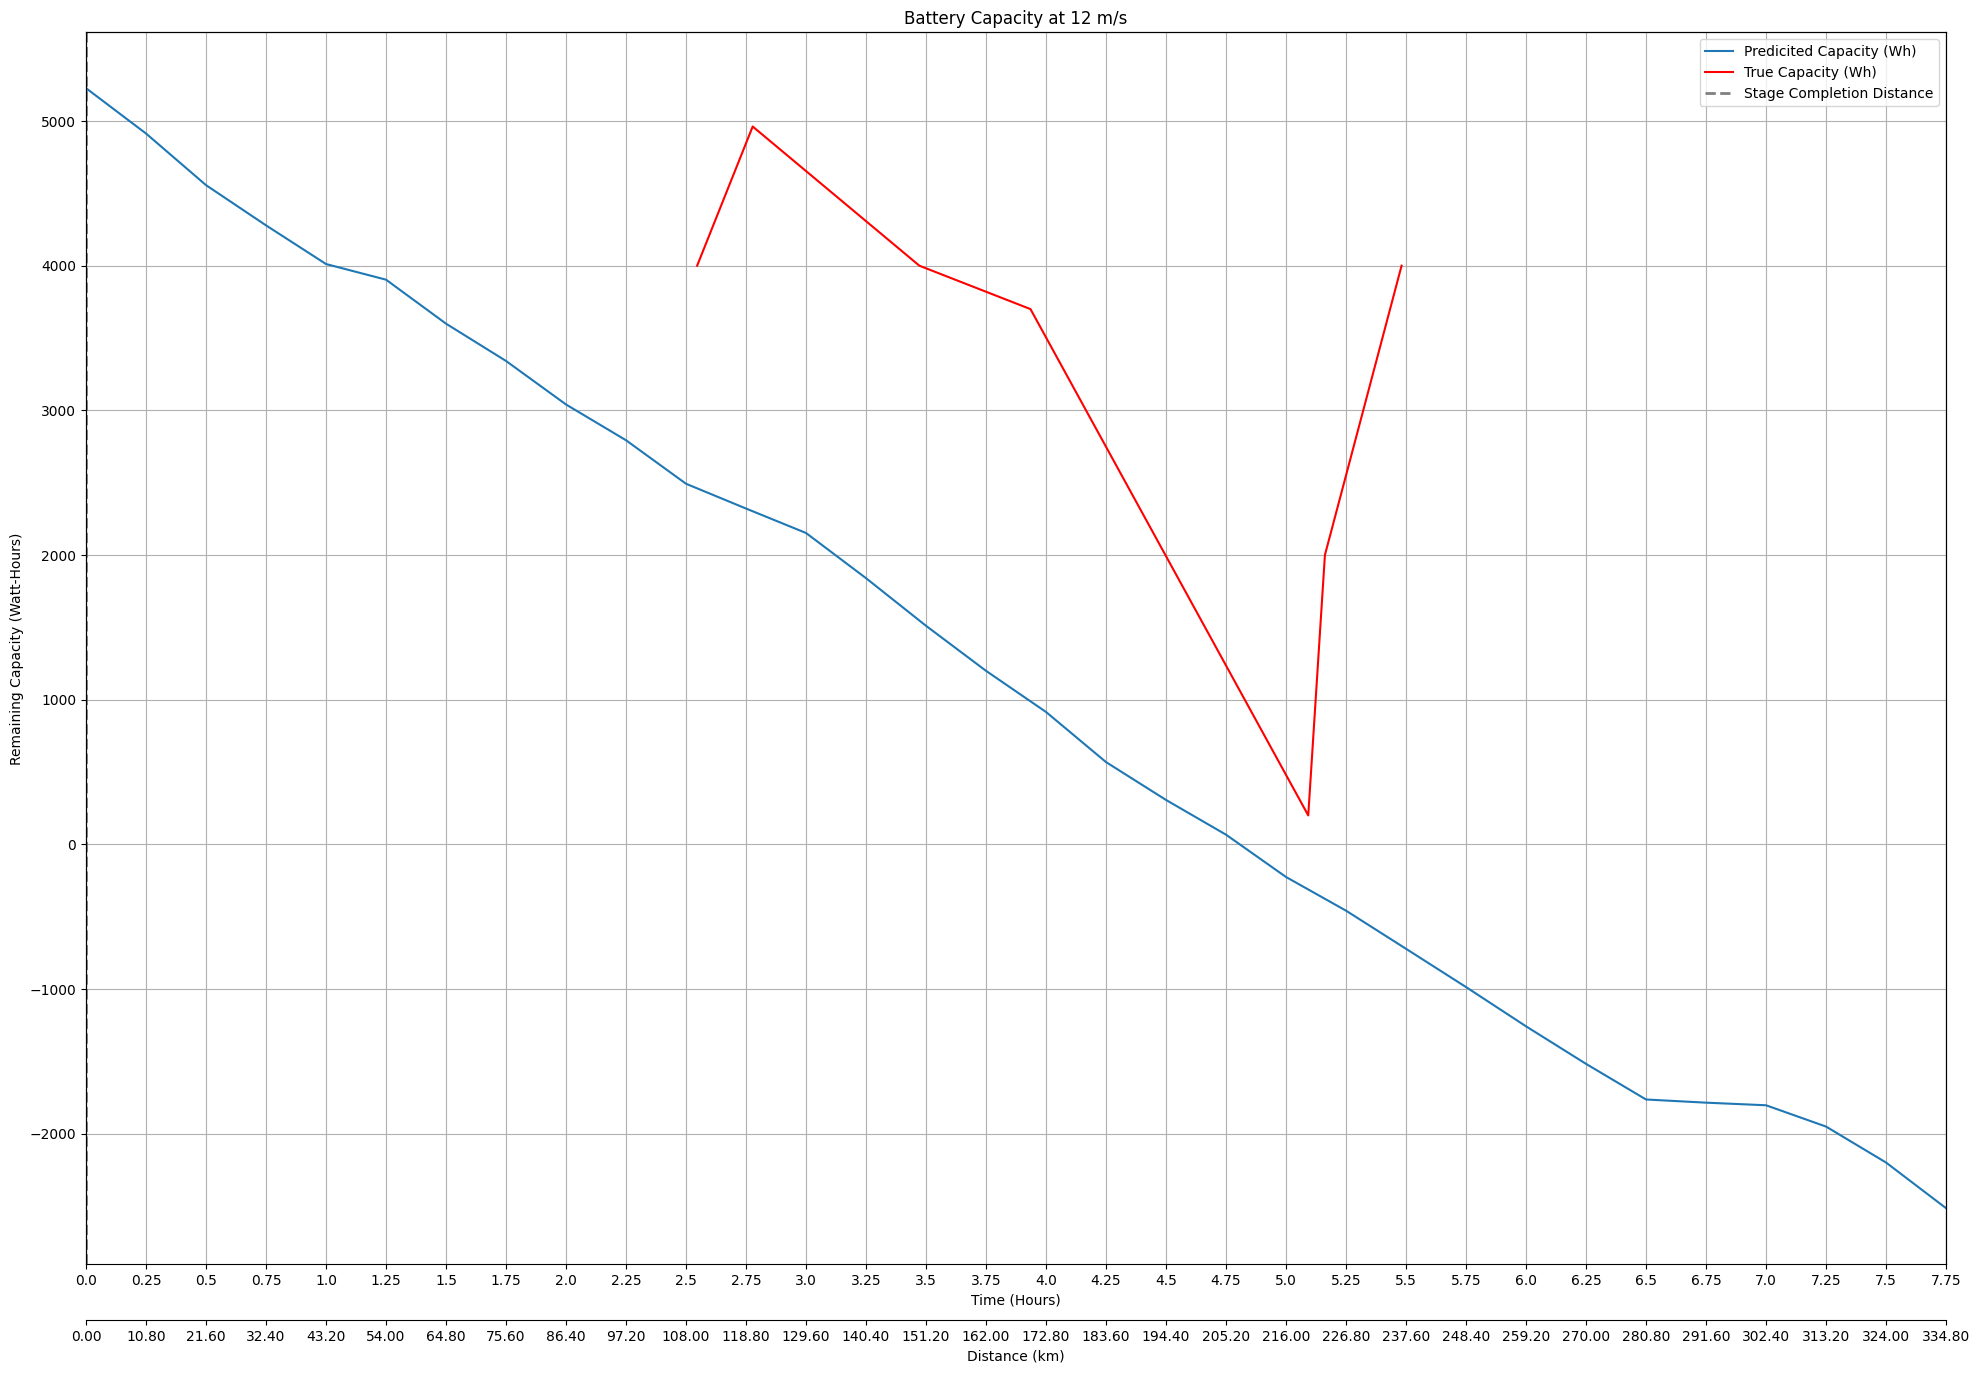

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_capacity(velocity, overlay_data, overlay_dist):

    scale_fac = velocity*inter/1000
    overlay_dist = overlay_dist.astype(float)
    overlay_dist -= current_d/1000
    overlay_dist /= scale_fac

    fig, ax1 = plt.subplots(figsize=(24, 16)) 
    ax1.plot(capacity_values[velocity, :], label='Predicited Capacity (Wh)')
    ax1.plot(overlay_dist, overlay_data, label='True Capacity (Wh)', color='red') 
   
    ax1.set_xlabel('Time (Hours)')
    ax1.set_ylabel('Remaining Capacity (Watt-Hours)')
    ax1.set_title(f'Battery Capacity at {velocity} m/s')

    ax1.set_xticks(np.arange(0, capacity_values.shape[1]))
    ax1.set_xticklabels([f'{i/4}' for i in range(capacity_values.shape[1])])
    
    ax2 = ax1.twiny()
    ax2.set_xlabel('Distance (km)')
    ax2.set_xticks(np.arange(0, capacity_values.shape[1]))
    ax2.set_xticklabels([f'{(current_d+velocity*inter*i)/1000:.2f}' for i in range(capacity_values.shape[1])]) 
    
    x_values = np.arange(0, capacity_values.shape[1])
    threshold_index = np.argmax((current_d+ velocity * inter * x_values) / 1000 >= stage_d / 1000)
    ax1.axvline(x=x_values[threshold_index], color='grey', linestyle='--', linewidth=2, label='Stage Completion Distance')
    ax1.legend(loc='upper right') 

    ax1.set_xlim(ax2.get_xlim())
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 40))

    ax1.legend()
    ax1.grid(True)

    plt.show()

# User Input
velocity = 12
overlay_data = np.array([4000, 4962, 4000, 3700, 200, 2000, 4000])  # real capacity data (Wh)
overlay_dist = np.array([110, 120, 150, 170, 220, 223, 236.80])  # corresponding distance (km)
plot_capacity(velocity, overlay_data, overlay_dist)

## FAQ

[WIP]

What does negative instantaneous power mean? \
How can we generate power going on a downhill? \
Important unit conversions? \
Accuracy \
What does negative capacity mean?


## TODO

Testable DB in the repo \
Clean up DB code, consodlidate \
Finish documentation 